### Popmodel - Linear Regression Modelling
##### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
from sklearn.preprocessing import OrdinalEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_validate
import imblearn
from math import sqrt

##### Notebook Settings

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

sns.set_style("whitegrid")

plt.rcParams.update({'figure.figsize': (12.0, 12.0)})
plt.rcParams.update({'font.size': 14})

##### Feature Engineering

In [3]:
#Read CSVs
data = pd.read_csv("SpotifyData.csv")
add_infos = pd.read_csv("additional_infos.csv")

In [4]:
#Adjust inconsistent genre naming
data.loc[data["genre"] == 'Children’s Music', "genre"] = "Children Music"
data.loc[data["genre"] == "Children's Music", "genre"] = "Children Music"

In [5]:
#Join duplicate tracks assigned to different genres together in one common row
genre_df = data.groupby(['track_id'])['genre'].apply(', '.join).reset_index()

In [6]:
#Drop duplicates by track ID and remove ID column
data.drop_duplicates("track_id", inplace=True)
data.sort_values("track_id", inplace=True)
data.reset_index(inplace=True, drop=True)

In [7]:
#Assign Features
X = data

In [8]:
#Replace genre column in original dataset
data["genre"] = genre_df["genre"]

In [9]:
#Genre encoding seperate since there can be multiple values in one row
X = pd.concat([X, X['genre'].str.get_dummies(sep=', ')], axis=1)
X = pd.concat([X, pd.get_dummies(X[["key", "time_signature"]])], axis=1)
X.drop(["key", "time_signature","genre"], axis=1, inplace=True)

In [10]:
#Add explicit feature from external dataset
add_infos.sort_values("id", inplace=True)
assert pd.Series(add_infos["id"].values == X["track_id"].values).value_counts().values[0] == len(add_infos)
X["explicit"] = add_infos["explicit"]
X["track_number"] = add_infos["track_number"]

In [11]:
#Get release Date from String and create new feature
temp = []
for i in range(len(add_infos)):
    temp += [int(add_infos["album"][i][add_infos["album"][i].find("release_date") + 16: add_infos["album"][i].find("release_date") + 20])]
X["release_date"] = temp
X.loc[X["release_date"] == 0000, "release_date"] = X["release_date"].values.mean().round()

In [12]:
#Get total track number from String and create new feature
temp = []
for i in range(len(add_infos)):
    if add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 16] == ",":
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 16])]
    elif add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 17] == ",":
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 17])]
    else:
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 18])]
X["total_tracks"] = temp

In [13]:
#Get artist id from String and create new feature
temp = []
for i in range(len(add_infos)):
    temp += [add_infos["album"][i][add_infos["album"][i].find("id") + 6: add_infos["album"][i].find("id") + 28]]
X["artist_id"] = temp

In [14]:
#encoding track id and artist
lenc = OrdinalEncoder()
X["track_id"] = lenc.fit_transform(X["track_id"].values.reshape(-1,1))
X["artist_id"] = lenc.fit_transform(X["artist_id"].values.reshape(-1,1))
X["track_name"] = lenc.fit_transform(X["track_name"].values.reshape(-1,1))
X["artist_name"] = lenc.fit_transform(X["artist_name"].values.reshape(-1,1))

In [155]:
#Drop Songs with zero popularity
X.drop(X[X["popularity"] == 0].index, inplace=True)


170604

In [189]:
#Drop voice only audio tracks (i.e. Podcasts)
X.drop(X[X["speechiness"] > 0.70].index, inplace=True)
len(X)

167567

In [190]:
#Assign Prediction Target
y = X["popularity"]
X.drop(["popularity"], axis=1, inplace=True)

In [ ]:
# Drop the categorical columns
X.drop(["track_id", "artist_name", "track_name", "artist_id"], axis=1, inplace=True)

In [ ]:
#Scaling all features (Results in lower score)
minni = MinMaxScaler()
pd.DataFrame(minni.fit_transform(X))

In [ ]:
#Normalizing features that are not normally distributed
normi = Normalizer()
pd.DataFrame(normi.fit_transform(pd.DataFrame(X["acousticness"])))
#X[["acousticness", "duration_ms", "instrumentalness", "liveness", "loudness", "speechiness", "total_tracks", "release_date", "track_number"]] = pd.DataFrame(normi.fit_transform(X[["acousticness", "duration_ms", "instrumentalness", "liveness", "loudness", "speechiness", "total_tracks", "release_date", "track_number"]]))
#X_normed.columns = X.columns
X["acousticness"]

##### Models

In [ ]:
#Validation Set
X_valid = X.sample(frac=0.1,random_state=1, replace=False)
X.drop(X_valid.index, inplace=True)

y_valid = y.iloc[X_valid.index]
y.drop(y_valid.index, inplace=True)

X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X_valid.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)

In [191]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3, shuffle=True)

In [ ]:
#Over and undersampling (Results in lower score)
smote = imblearn.over_sampling.SMOTE(sampling_strategy='minority', random_state=3, n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train,y_train)
len(X)

In [ ]:
#PopModel
rfr = RandomForestRegressor(min_samples_leaf=2, n_estimators=125, verbose=1, n_jobs=-1)

#Fit
rfr.fit(X_train, y_train)

#Predict Traindata
pred_train = rfr.predict(X_train)
sns.regplot(y_train, pred_train)

In [195]:
#Predict Testdata
pred_test = rfr.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:    0.4s finished


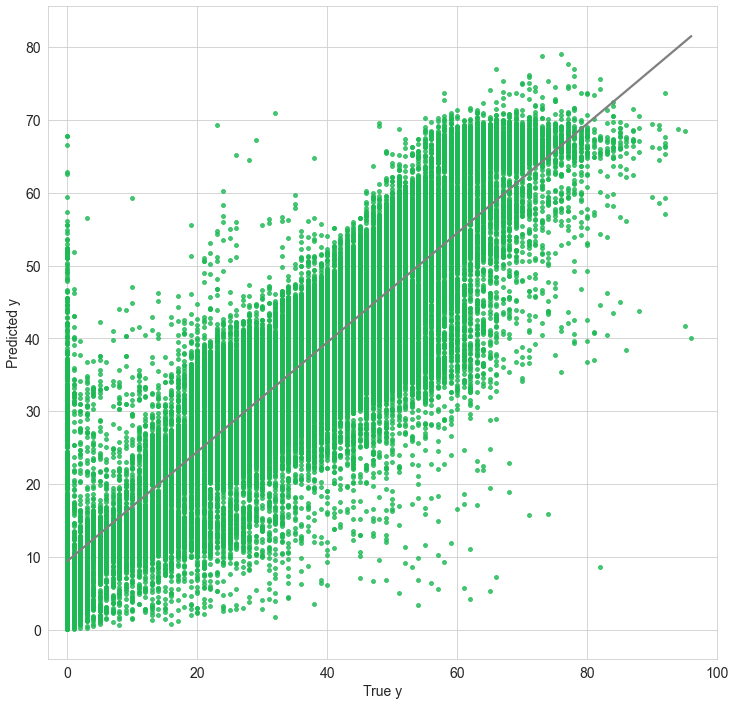

In [197]:
seab = sns.regplot(y_test, pred_test, scatter_kws={"color": "#1DB954", "s": 15}, line_kws={"color": "gray"}, fit_reg=True, ci=None)
seab.set(xlabel='True y', ylabel='Predicted y', xlim=(-3, 100))
plt.savefig("regplot.png")

In [198]:
#Metrics
RMSE = sqrt(mean_squared_error(y_test, pred_test.round().astype(int).tolist()))
print("RMSE: " + str(RMSE))

MAE = mean_absolute_error(y_test, pred_test.round().astype(int).tolist())
print("MAE: " + str(MAE))

r2 = r2_score(y_test, pred_test.round().astype(int).tolist())
print("R²: " + str(r2))

RMSE: 8.51841571758798
MAE: 6.17403672097233
R²: 0.7568970018934947


In [ ]:
#Cross Validation
scores = cross_validate(rfr, X, y, cv=5, scoring=('r2', 'neg_mean_squared_error', "neg_median_absolute_error", 'neg_mean_absolute_error'), return_train_score=True)

print("test_r2: %0.2f (+/- %0.2f)" % (scores["test_r2"].mean(), scores["test_r2"].std() * 2))
print("test_neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores["test_neg_mean_squared_error"].mean(), scores["test_neg_mean_squared_error"].std() * 2))
print("test_neg_median_absolute_error: %0.2f (+/- %0.2f)" % (scores["test_neg_median_absolute_error"].mean(), scores["test_neg_median_absolute_error"].std() * 2))
print("test_neg_mean_absolute_error: %0.2f (+/- %0.2f)" % (scores["test_neg_mean_absolute_error"].mean(), scores["test_neg_mean_absolute_error"].std() * 2))

In [ ]:
###GridSearchCV


params = { "n_estimators": [100]
           }

gsearch = GridSearchCV(estimator=m,
                       param_grid=params,
                       cv=5,
                       verbose=1,
                       n_jobs=-1
                       )


gsearch.fit(X_train, y_train)

print("\nScore: " + str(round(gsearch.score(X_train, y_train),4)))

print("\nBest Parameters: "+ str(gsearch.best_params_))


##### Additional Model Testing

In [ ]:
from sklearn.linear_model import LinearRegression
# RMSE: 9.7
# MAE: 7.35
# R²: 0.633
from sklearn.linear_model import Lasso #RMSE: 14.61
from sklearn.linear_model import LassoLars #RMSE: 16.07
from sklearn.linear_model import Ridge #same as linear regression
from sklearn.linear_model import RidgeCV #same as linear regression
from sklearn.linear_model import BayesianRidge #same as linear regression
from sklearn.linear_model import TheilSenRegressor #same as linear regression
from xgboost import XGBRegressor
# RMSE: 8.300204795862877
# MAE: 6.284962437051102
# R²: 0.7331425830142111

In [ ]:
model = XGBRegressor(seed=27, colsample_bytree=0.9, subsample=0.8,
                       gamma=0.2, min_child_weight=1, max_depth=5, n_estimators=1000, learning_rate =0.3,
                       sampling_method="gradient_based", random_state=3, n_jobs=-1, tree_method='gpu_hist',
                       predictor= 'gpu_predictor', verbosity=2)


model.fit(X_train, y_train)


pred = model.predict(X_test)

RMSE = sqrt(mean_squared_error(y_test, pred.round().astype(int).tolist()))
print("RMSE: " + str(RMSE))

MAE = mean_absolute_error(y_test, pred.round().astype(int).tolist())
print("MAE: " + str(MAE))

r2 = r2_score(y_test, pred.round().astype(int).tolist())
print("R²: " + str(r2))